In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!nvidia-smi

Mon Nov 18 19:48:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%pip install nlpaug

     |████████████████████████████████| 92kB 3.4MB/s 


In [0]:
%pip install torch>=1.2.0 transformers>=2.0.0

In [0]:
%tensorflow_version 1.x
import pandas as pd
import time

import numpy as np
from numpy.random import seed
seed(9)

import tensorflow as tf
from tensorflow import set_random_seed
set_random_seed(9)

import json
import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re

nltk.download("popular")
print(tf.__version__)

Using TensorFlow backend.


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [0]:
dataover = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_def.csv", sep='#',encoding='utf-8', lineterminator='\n')
taste = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_Jaime_def.csv", sep='#', encoding='utf-8')

In [0]:
taste = taste[~taste['id'].str.contains('/')]
taste['id'] = taste['id'].astype(int)

In [0]:
# Merge taste and credits

data = taste.merge(dataover[['id','title','overview','genres','crew','cast']], left_on='id', right_on='id')

In [0]:
data

,id,like,title,overview,genres,crew,cast
0,5,NaN,Four Rooms,"Durante una Nochevieja, en un hotel de Los Áng...","[{'id': 80, 'name': 'Crimen'}, {'id': 35, 'nam...","[{'credit_id': '52fe420dc3a36847f800011b', 'de...","[{'cast_id': 42, 'character': 'Ted the Bellhop..."
1,11,1.0,La guerra de las galaxias. Episodio IV: Una nu...,"La princesa Leia, líder del movimiento rebelde...","[{'id': 12, 'name': 'Aventura'}, {'id': 28, 'n...","[{'credit_id': '52fe420dc3a36847f8000437', 'de...","[{'cast_id': 3, 'character': 'Luke Skywalker',..."
2,12,1.0,Buscando a Nemo,"Nemo, un pececillo, hijo único muy querido y p...","[{'id': 16, 'name': 'Animación'}, {'id': 10751...","[{'credit_id': '52fe420ec3a36847f8000653', 'de...","[{'cast_id': 8, 'character': 'Marlin (voice)',..."
3,13,1.0,Forrest Gump,Forrest Gump es un chico con deficiencias ment...,"[{'id': 35, 'name': 'Comedia'}, {'id': 18, 'na...","[{'credit_id': '52fe420ec3a36847f800072d', 'de...","[{'cast_id': 7, 'character': 'Forrest Gump', '..."
4,14,NaN,American Beauty,"Divertida, inquietante y sorprendente incursió...","[{'id': 18, 'name': 'Drama'}]","[{'credit_id': '52fe420ec3a36847f80007c5', 'de...","[{'cast_id': 6, 'character': 'Lester Burnham',..."
...,...,...,...,...,...,...,...
11549,397511,NaN,Misfortune,"Boyd, un mecánico desempleado, deberá buscar l...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'credit_id': '57376693c3a36823b40038ad', 'de...","[{'cast_id': 1, 'character': 'Boyd', 'credit_i..."
11550,348413,NaN,Tango argentino,La profesora de tango argentina Valentina Mart...,"[{'id': 18, 'name': 'Drama'}]","[{'credit_id': '55a26d71925141296e003744', 'de...","[{'cast_id': 1, 'character': 'Valentina Martin..."
11551,461264,NaN,Ya no siento nada,Él es un mago. Ella es una bombera. Aislándose...,"[{'id': 16, 'name': 'Animación'}]","[{'credit_id': '593b31ee925141059b0024b3', 'de...",[]
11552,429691,NaN,El proyecto supermente,"En Los Ángeles, la tierra se estremece, la ge...","[{'id': 28, 'name': 'Acción'}, {'id': 53, 'nam...","[{'credit_id': '584c723b9251411e35002a5b', 'de...","[{'cast_id': 1, 'character': 'General White', ..."


In [0]:
data = data[~pd.isna(data.overview)]
len(data)

11166

In [0]:
data = data.dropna(subset=['like'])
data['like'] = data['like'].astype(int)
data.reset_index(inplace=True,drop=True)
len(data)

1109

In [0]:
# Clean overviews ver que ocurre con deadpool y deadpool 2 

import string

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist() + ['secuela']

def normalize(s):
  s = s.lower()
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u"),
      ("ñ", "n")
  )
  for a, b in replacements:
      s = s.replace(a, b).replace(a.upper(), b.upper())
  return s

def split_punt(x):
  words = WordPunctTokenizer().tokenize(x)
  x = str(' '.join(words))
  x = re.sub(' +', ' ', x)
  return x

def delete_stop_words(x):
  x = x.translate(str.maketrans('','',string.punctuation))
  x = x.translate(str.maketrans('','','1234567890ªº¡¿'))
  words = x.split(' ')
  words = [word for word in words if word not in stop_words]
  x = str(' '.join(words))
  return x

In [0]:
data['overview']= data['overview'].apply(lambda x: split_punt(x))

In [0]:
# Steaming overview

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
  stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
  return " ".join(stemmed_text)
  

In [0]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

aug = naf.Sequential([
    naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-cased', action="insert", aug_p=0.1),
    naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-cased', action="substitute", aug_p=0.9),
    naw.RandomWordAug(action="delete", aug_p=0.1)
])

def augment(x):
  try:
    return aug.augment(x)
  except:
    return None


In [0]:
# Get staff and paste to overview

def eval_cell(cell):
  
  try:
    
    cell_array = eval(cell)
  
  except:
    
    cell_array = []
  
  return cell_array

def get_actors(cast):
  
  eval_cast = eval_cell(cast)
  
  if len(eval_cast) > 2:
    up = 3
  else:
    up = len(eval_cast)

  actors = ''
  
  for i in range(0,up):
    actor = eval_cast[i]['name']
    actor = normalize(actor.replace(' ','_').lower())
  
    actors = actors + ' ' + actor
  
  return actors

def get_director(crew):
  
  eval_crew = eval_cell(crew)
  
  directors = [member['name'] for member in eval_crew if member['job'] == 'Director']
  directors = [normalize(director.replace(' ','_').lower()) for director in directors]
  directors = str(' '.join(directors))
  
  return directors

In [0]:
from sklearn.model_selection import train_test_split

df = data[['overview','cast','crew','like']]

train, test = train_test_split(df, test_size=0.15, stratify=df['like'], random_state=1996)

In [0]:
# Generate training data

train_aug_1 = train.copy()
train_aug_1['overview'] = train_aug_1['overview'].apply(lambda x: augment(x))
train_aug_1 = train_aug_1.dropna(subset=['overview'])

train_aug_2 = train_aug_1.copy()
train_aug_2['overview'] = train_aug_2['overview'].apply(lambda x: augment(x))
train_aug_2 = train_aug_2.dropna(subset=['overview'])

In [0]:
train.iloc[0].overview

'La supervivencia de la humanidad pende de un hilo , pero Beck , un héroe mortal , está decidido a salvar el mundo y a rescatar a su verdadero amor . Para conseguirlo busca la ayuda del poderoso dios Horus , con el que establecerá una alianza contra Set , el despiadado dios de la oscuridad que ha usurpado el trono de Egipto , sumiendo al país en el caos . Para ganar la batalla contra Set y sus secuaces tendrán que someterse a terribles pruebas de valentía y sacrificio .'

In [0]:
train_aug_1.iloc[0].overview

'La de su humanidad pende de nuevo hilo , pero Beck , un héroe solitario , a no salvar el y a rescatar a su verdadero amor . Para conseguirlo la ayuda técnica del poderoso Horus , con el que establecerá una alianza contra Set , es el despiadado y dios la oscuridad que ha usurpado definitivamente el dominio original de Egipto , sumiendo al país en el caos . terminar la batalla contra Set y sus secuaces tendrán que someterse a terribles pruebas y valentía y de sacrificio .'

In [0]:
train_aug_2.iloc[0].overview

'La de su humanidad pende al nuevo hilo , pero Beck , un héroe virtual solitario , puede no salvar el tiempo a rescatar a su verdadero mundo . Para conseguirlo ayuda y técnica del prominente príncipe Horus , con el objetivo se establecerá una alianza contra Set , es el despiadado y dios la oscuridad que ha usurpado definitivamente su dominio ( original ) de , sumiendo al país por caos . terminar la batalla contra Set sus secuaces tendrán que someterse o moral de y de sacrificio .'

In [0]:
train_new = train.append(train_aug_1).append(train_aug_2)

def transform_over(df):
  df['overview'] = df['overview'].apply(lambda x: normalize(x))
  df['overview'] = df['overview'].apply(lambda x: delete_stop_words(x))
  df['overview'] = df['overview'].apply(lambda x: stem_sentence(x))
  df['overview'] = df.apply(lambda x: get_actors(x['cast']) + ' ' + x['overview'] , axis=1)
  df['overview'] = df.apply(lambda x: get_director(x['crew']) + x['overview'] , axis=1)
  df['overview'] = df['overview'].apply(lambda x: normalize(x))
  df['overview'] = df['overview'].apply(lambda x: delete_stop_words(x))

  return df

train_new = transform_over(train_new).reset_index()
test_new = transform_over(test).reset_index()

X_train = train_new.overview.values
y_train = train_new.like.values
X_test = test_new.overview.values
y_test = test_new.like.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [0]:
columns_train = {'overview': X_train, 'like': y_train}
train_df = pd.DataFrame(data=columns_train)
train_df.to_csv('gdrive/My Drive/TFG/train' + '.csv', sep=';', encoding='utf-8', index=False)

columns_test = {'overview': X_test, 'like': y_test}
test_df = pd.DataFrame(data=columns_test)
test_df.to_csv('gdrive/My Drive/TFG/test' + '.csv', sep=';', encoding='utf-8', index=False)

In [0]:
train_df = pd.read_csv('gdrive/My Drive/TFG/train.csv', sep=';', encoding='utf-8')
test_df = pd.read_csv('gdrive/My Drive/TFG/test.csv', sep=';', encoding='utf-8')

X_train = train_df.overview.values
y_train = train_df.like.values
X_test = test_df.overview.values
y_test = test_df.like.values

count    2788.000000
mean       41.519727
std        15.836761
min         8.000000
25%        30.000000
50%        40.000000
75%        52.000000
max        91.000000
Name: overview, dtype: float64


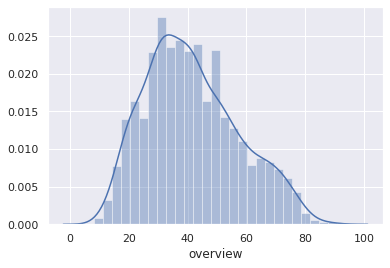

In [0]:
import seaborn as sns
sns.set(color_codes=True)

over_lenghts = train_df.overview.str.split().apply(len)
print(over_lenghts.describe())

sns.distplot(over_lenghts)

In [0]:
X_test[0]

'gasparnoe nathanielbrown pazdelahuerta cyrilroy oscar herman lind viv toky sobreviv trafic drog stripp club nocturn forceje polici oscar cae her dispar agoniz espiritu fiel promes abandon herman rechaz abandon mund viv espiritu vag ciud vision caotic filmaffinity'

In [0]:
# Embedding
num_words = 8000
maxlen = 80

In [0]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
print(X_train[2]) 

X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

print(X_train[2]) 
print(vocab_size)

# Max length vector
len(max(X_train, key=len))

davidayer willsmith margotrobbie joelkinnaman gobiern ee uu respond visit alienigen tierr intencion malign amand mur wall lid agenci secret ofrec curios solucion reclut villan cruel habil letal magic trabaj demasi opcion negat supervillan peligr mund acced colabor ejecut peligr mision secret suic logr limpi expedient
[2414, 585, 1570, 1916, 465, 998, 1399, 1186, 138, 159, 21, 353, 342, 907, 1703, 1296, 274, 406, 24, 335, 1571, 405, 296, 106, 734, 244, 508, 197, 235, 2281, 908, 1704, 1806, 20, 2, 1474, 466, 1187, 20, 33, 24, 1917, 108, 909, 948]
10162


91

In [0]:
max([max(i) for i in X_train])

10161

In [0]:
tokenizer.word_index

{'vid': 1,
 'mund': 2,
 'jov': 3,
 'anos': 4,
 'cas': 5,
 'amig': 6,
 'hij': 7,
 'viv': 8,
 'padr': 9,
 'descubr': 10,
 'human': 11,
 'llam': 12,
 'famili': 13,
 'ayud': 14,
 'conoc': 15,
 'enfrent': 16,
 'histori': 17,
 'decid': 18,
 'misteri': 19,
 'peligr': 20,
 'tierr': 21,
 'lleg': 22,
 'pequen': 23,
 'secret': 24,
 'busc': 25,
 'hombr': 26,
 'agent': 27,
 'unic': 28,
 'salv': 29,
 'grup': 30,
 'form': 31,
 'luch': 32,
 'mision': 33,
 'viaj': 34,
 'ciud': 35,
 'encontr': 36,
 'nin': 37,
 'pas': 38,
 'equip': 39,
 'acab': 40,
 'unk': 41,
 'muert': 42,
 'herman': 43,
 'muj': 44,
 'antigu': 45,
 'tendr': 46,
 'cre': 47,
 'chic': 48,
 'fuerz': 49,
 'aventur': 50,
 'planet': 51,
 'dej': 52,
 'cambi': 53,
 'futur': 54,
 'vuelv': 55,
 'guerr': 56,
 'madr': 57,
 'pelicul': 58,
 'convert': 59,
 'seri': 60,
 'polici': 61,
 'deber': 62,
 'qued': 63,
 'joven': 64,
 'asesin': 65,
 'tom': 66,
 'especial': 67,
 'amenaz': 68,
 'llev': 69,
 'regres': 70,
 'objet': 71,
 'rein': 72,
 'jam': 73,
 '́'

In [0]:
# Save tokenizer
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)

In [0]:
# # Crear pre-trained emmbeding

# def create_embedding_matrix(filepath, word_index, embedding_size):
#     vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
#     embedding_matrix = np.zeros((vocab_size, embedding_size))

#     with open(filepath, encoding='utf-8') as f:
#         for line in f:
#             word, *vector = line.split()
#             if word in word_index:
#                 idx = word_index[word] 
#                 embedding_matrix[idx] = np.array(
#                     vector, dtype=np.float32)[:embedding_size]

#     return embedding_matrix
  
# embedding_matrix = create_embedding_matrix(
#     'gdrive/My Drive/TFG/SBW-vectors-300-min5.txt',
#     tokenizer.word_index, embedding_size)

# print(embedding_matrix[2])
# print(len(embedding_matrix[2]))

# nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
# nonzero_elements / vocab_size

In [0]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)

X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 4923,  822, 4924, 1914, 1237, 1294,    6,
       4925, 2865, 8951, 2413, 4926,  405,   19, 1569,  302,  788, 1915,
       4254, 1237, 1294,    6,  109, 4927, 4590,  272, 1185, 4255, 4928,
       1295,  334,   68, 1398, 4929,   97, 1237,  872, 1805,  272,   55,
        423,   81, 3044], dtype=int32)

In [0]:
#from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping

#Optimizer

from keras import optimizers

adam = optimizers.Adam()

In [0]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights

array([0.97755961, 1.02349486])

In [0]:
# # Model 1

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation
# from tensorflow.keras.layers import Embedding
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# model = Sequential()

# model.add(Embedding(vocab_size,embedding_size, input_length=maxlen))
# model.add(GlobalMaxPooling1D())
# model.add(Dropout(0.5))
# model.add(Dense(500, activation='elu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.5))
# model.add(Dense(500, activation='elu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.5))
# model.add(Dense(500, activation='elu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))
# model.compile(optimizer=adam,
#               loss='binary_crossentropy',
#               metrics=['acc'])

# model.summary()


In [0]:
# # Model 2

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation
# from tensorflow.keras.layers import Embedding, BatchNormalization
# from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D,GlobalAveragePooling1D

# model = Sequential()

# # we start off with an efficient embedding layer which maps
# # our vocab indices into embedding_dims dimensions
# model.add(Embedding(vocab_size,
#                     embedding_size,
#                     input_length=maxlen))


# # we add a Convolution1D, which will learn filters
# # word group filters of size filter_length:
# model.add(Conv1D(filters,
#                  kernel_size,
#                  padding='valid',
#                  strides=1, kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Activation('elu'))

# # we use max pooling:

# model.add(GlobalMaxPooling1D())

# # We add a vanilla hidden layer:
# model.add(Dense(150, kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Activation('elu'))
# model.add(Dropout(0.5))

# # We project onto a single unit output layer, and squash it with a sigmoid:
# model.add(Dense(1))
# model.add(BatchNormalization())
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer=tf.keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
#               metrics=['accuracy'])

# model.summary()

In [0]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Convolution1D, MaxPooling1D, Input
from keras.layers import Embedding,CuDNNLSTM, SpatialDropout1D, Reshape, Flatten, BatchNormalization
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from keras.optimizers import Adam, Adagrad


class MyLayers:

    @staticmethod
    def my_conv1d(kernel_size, layer, filters=10, strides=1, act='relu', reg=None):
        
        c1d = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', strides=strides,
                                     kernel_initializer='he_uniform', kernel_regularizer=reg)(layer)
        
        if act in ['relu','elu','gelu','sigmoid']:
          if act == 'gelu':
            act = MyLayers.gelu
          c1d = keras.layers.BatchNormalization()(c1d)
          c1d = keras.layers.Activation(act)(c1d)
        
        else:
          c1d = keras.layers.Activation(act)(c1d)
          c1d = keras.layers.BatchNormalization()(c1d)
          
        return c1d

    @staticmethod
    def my_dense(neurons, ant, act='sigmoid', ini='glorot_uniform', reg=None):
      
        dense = keras.layers.Dense(neurons, kernel_initializer=ini, kernel_regularizer=reg)(ant)

        if act in ['relu','elu','gelu','sigmoid']:
          if act == 'gelu':
            act = MyLayers.gelu
          dense = keras.layers.BatchNormalization()(dense)
          dense = keras.layers.Activation(act)(dense)
        
        else:
          dense = keras.layers.Activation(act)(dense)

        return dense

    @staticmethod
    def gelu(x):
        return 0.5 * x * (1 + tf.keras.backend.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * tf.keras.backend.pow(x, 3))))

    @staticmethod
    def custom_sigmoid(x):
        return keras.backend.sigmoid(x) + tf.keras.backend.epsilon()


In [0]:
# # Model 3

# words = Input(shape=(maxlen,))
# em =  Embedding(input_dim = vocab_size, output_dim = embedding_size, weights=[embedding_matrix], trainable=True)(words)
# em = Dropout(0.3)(em) 
# c1 = my_conv1d(2,em, filters=500)
# c2 = my_conv1d(3,em, filters=500)
# c3 = my_conv1d(5,em, filters=500)

# g1 = GlobalMaxPooling1D()(c1)
# g2 = GlobalMaxPooling1D()(c2)
# g3 = GlobalMaxPooling1D()(c3)

# con = Concatenate(axis=1)([g1,g2,g3])

# dense = Dropout(0.5)(con) 
# pred = my_dense(1,dense)
# model = Model(inputs=words, outputs=pred)

# model.compile(optimizer = 'adam',
#               loss = 'binary_crossentropy',
#               metrics = ['accuracy'])
  
# model.summary()


In [0]:
# # Model RNN

# from tensorflow.keras.layers import Bidirectional, LSTM, Flatten

# words = Input(shape=(maxlen,))
# em =  Embedding(input_dim = vocab_size, output_dim = embedding_size, weights=[embedding_matrix], trainable=True)(words)
# #em = Dropout(0.3)(em) 

# lstm_1 = Bidirectional(LSTM(64, name='blstm_1',
# activation='tanh',
# recurrent_activation='hard_sigmoid',
# recurrent_dropout=0.0,
# dropout=0.5, 
# kernel_initializer='glorot_uniform',
# return_sequences=True),
# merge_mode='concat')(em)

# lstm_1 = BatchNormalization()(lstm_1)

# #Flatten
# g1 = Flatten()(lstm_1)

# drop3 = Dropout(0.5)(g1)

# pred = my_dense(1,drop3)
# model = Model(inputs=words, outputs=pred)

# model.compile(optimizer = 'adam',
#               loss = 'binary_crossentropy',
#               metrics = ['accuracy'])
  
# model.summary()

In [0]:
# Model 5 cnn + rnn

from keras.layers import Bidirectional, CuDNNGRU, GRU, SpatialDropout1D

def custom_model_gpu(embedding_size, dropout, filters, kernel, maxp, gnup, neurons, act):
  words = Input(shape=(maxlen,))
  em =  Embedding(input_dim = vocab_size, output_dim = embedding_size)(words)
  em = SpatialDropout1D(dropout)(em) 

  c = MyLayers.my_conv1d(kernel ,em, filters=filters, act=act)
  m = MaxPooling1D(pool_size=maxp)(c)
  d = Dropout(dropout)(m) 

  gru = CuDNNGRU(gnup, kernel_initializer='glorot_uniform', return_sequences=True)(d)
  gru = BatchNormalization()(gru)
  gru = GlobalMaxPooling1D()(gru)
  drop = Dropout(dropout)(gru)

  pred = MyLayers.my_dense(neurons=neurons, ant=drop, act=act)
  pred = MyLayers.my_dense(1, pred, act='sigmoid')

  model = Model(inputs=words, outputs=pred)

  return model

def custom_model_cpu(embedding_size, dropout, filters, kernel, maxp, gnup, neurons, act):
  words = Input(shape=(maxlen,))
  em =  Embedding(input_dim = vocab_size, output_dim = embedding_size)(words)
  em = SpatialDropout1D(dropout)(em) 

  c = MyLayers.my_conv1d(kernel ,em, filters=filters, act=act)
  m = MaxPooling1D(pool_size=maxp)(c)
  d = Dropout(dropout)(m) 

  gru = GRU(gnup, kernel_initializer='glorot_uniform', activation='tanh',
            recurrent_activation='sigmoid', return_sequences=True, reset_after=True)(d)
  gru = BatchNormalization()(gru)
  gru = GlobalMaxPooling1D()(gru)
  drop = Dropout(dropout)(gru)

  pred = MyLayers.my_dense(neurons=neurons, ant=drop, act=act)
  pred = MyLayers.my_dense(1, pred)

  model = Model(inputs=words, outputs=pred)

  return model

In [0]:
import os
import glob

files = glob.glob("gdrive/My Drive/TFG/models/*")
for f in files:
    os.remove(f)

In [0]:
import os

files = os.listdir("gdrive/My Drive/TFG/models/")
files.sort(reverse=True)
print(files)

['weights-14-0.74.hdf5', 'weights-13-0.73.hdf5', 'weights-06-0.71.hdf5', 'weights-05-0.68.hdf5', 'weights-04-0.65.hdf5', 'weights-03-0.58.hdf5', 'weights-01-0.51.hdf5']


In [0]:
model = custom_model_gpu(embedding_size=150,dropout=0.5,filters=64,kernel=3,maxp=2,gnup=32,neurons=8,act='gelu')
model.load_weights("gdrive/My Drive/TFG/models/" + files[0])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',  metrics = ['accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 150)           1524300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 80, 150)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 78, 64)            28864     
_________________________________________________________________
batch_normalization_1 (Batch (None, 78, 64)            256       
___________________________________

In [0]:
from keras.callbacks import ModelCheckpoint

filepath="gdrive/My Drive/TFG/models/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, verbose=1)

In [0]:
def get_one_hot(x):
  if x==1:
    return [0,1]
  else:
    return [1,0]

In [0]:
y_train2 = np.array([get_one_hot(x) for x in y_train])
y_test2 = np.array([get_one_hot(x) for x in y_test])

In [0]:
y_train2

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]])

In [0]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    class_weight=class_weights,
                    callbacks=[checkpoint])

Train on 2788 samples, validate on 167 samples
Epoch 1/20
2788/2788 [==============================] - 13s 5ms/step - loss: 0.8099 - acc: 0.4821 - val_loss: 0.7116 - val_acc: 0.5090

Epoch 00001: val_acc improved from -inf to 0.50898, saving model to gdrive/My Drive/TFG/models/weights-01-0.51.hdf5
Epoch 2/20
2788/2788 [==============================] - 2s 817us/step - loss: 0.7463 - acc: 0.5352 - val_loss: 0.7185 - val_acc: 0.5090

Epoch 00002: val_acc did not improve from 0.50898
Epoch 3/20
2788/2788 [==============================] - 2s 805us/step - loss: 0.6344 - acc: 0.6496 - val_loss: 0.6620 - val_acc: 0.5808

Epoch 00003: val_acc improved from 0.50898 to 0.58084, saving model to gdrive/My Drive/TFG/models/weights-03-0.58.hdf5
Epoch 4/20
2788/2788 [==============================] - 2s 800us/step - loss: 0.4963 - acc: 0.8099 - val_loss: 0.6167 - val_acc: 0.6527

Epoch 00004: val_acc improved from 0.58084 to 0.65269, saving model to gdrive/My Drive/TFG/models/weights-04-0.65.hdf5
Ep

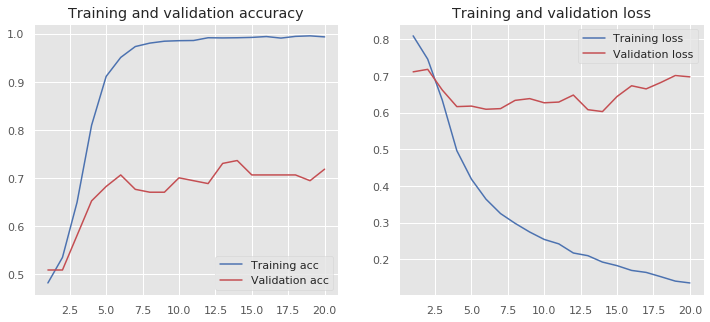

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [0]:
y_score = model.predict(X_test)
threshold = 0.5
#y_pred= model.predict_classes(X_neutral)
#y_test = y_netural

y_pred = y_score.copy()
y_pred[y_pred >=threshold] = 1
y_pred[y_pred <threshold] = 0

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Kappa: {:.4f}".format(cohen_kappa_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred,pos_label=1)))
print("Auc: {:.4f}".format(roc_auc_score(y_test, y_pred)))

Confusion Matrix: 
[[60 25]
 [19 63]]
Accuracy: 0.7365
Kappa: 0.4736
Precision: 0.7159
Recall: 0.7683
F1: 0.7412
Auc: 0.7371


In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72        85
           1       0.71      0.72      0.72        82

    accuracy                           0.72       167
   macro avg       0.72      0.72      0.72       167
weighted avg       0.72      0.72      0.72       167



In [0]:
model2 = custom_model_cpu(embedding_size=150,dropout=0.5,filters=64,kernel=3,maxp=2,gnup=32,neurons=8,act='gelu')
model2.load_weights("gdrive/My Drive/TFG/models/" + files[0])
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy',  metrics = ['accuracy'])

model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 80, 150)           1524300   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 80, 150)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 78, 64)            28864     
_________________________________________________________________
batch_normalization_5 (Batch (None, 78, 64)            256       
_________________________________________________________________
activation_4 (Activation)    (None, 78, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 64)            0   

In [0]:
model2.save('gdrive/My Drive/TFG/models/my_model_movie_like.h5') 

In [0]:
# Parameter space
param_grid = dict(dropout = [0.5],
                  filters1 = [256,512],
                  filters2 = [256,512],
                  kernel = [2,3],
                  maxp = [3,5],
                  gnup = [64,128,256],
                  act = ["relu", MyLayers.gelu],
                  epochs=[20])

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn = custom_model, verbose=1, batch_size = 8)

In [0]:
from sklearn.model_selection import RandomizedSearchCV

grid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, verbose=2, cv = 2)

In [0]:
grid_result = grid.fit(X_train, y_train)

In [0]:
grid.best_score_

0.5281385447383787

In [0]:
 # summarize results
means = pd.DataFrame(grid_result.cv_results_['mean_test_score'], columns = ['Mean'] )
stds = pd.DataFrame(grid_result.cv_results_['std_test_score'], columns = ['SD'])
params = pd.DataFrame(grid_result.cv_results_['params'])

result = pd.concat([means, stds, params],axis = 1).sort_values(by=['Mean'], ascending=False)
print(result.to_string(index=False))

     Mean        SD                                         act  dropout  epochs  filters1  filters2  gnup  kernel  maxp
 0.528139  0.009420  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       512    64       3     5
 0.518038  0.022393  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       256    64       3     5
 0.516595  0.020947  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       512   128       2     3
 0.516595  0.020947  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       512   256       3     3
 0.516595  0.020947  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       512   256       2     3
 0.516595  0.020947                                        relu      0.5      20       512       256   256       2     3
 0.516595  0.020947                                        relu      0.5      20       256       512   128       3     5
 0.516595  0.020947             

In [0]:
# Model 6 Attention with LSTM
from keras.engine.topology import Layer

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [0]:
from keras.layers import Bidirectional, CuDNNGRU, SpatialDropout1D
from keras.layers import Bidirectional
from keras.layers import GRU, CuDNNGRU

from keras import optimizers
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Convolution1D, MaxPooling1D, Input, AveragePooling1D
from keras.layers import Embedding, SpatialDropout1D, Reshape, Flatten, BatchNormalization
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from keras.optimizers import Adam, Adagrad

def model_lstm_atten(n_embedding,gru,act1,act2,neurons):
    inp = Input(shape=(maxlen,))
    x = Embedding(input_dim = vocab_size, output_dim = n_embedding)(inp)
    x = SpatialDropout1D(0.5)(x)
    x = CuDNNGRU(gru, kernel_initializer='glorot_uniform', return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = AttentionWithContext()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MyLayers.my_dense(neurons,x,act='relu', ini='he_uniform', reg=keras.regularizers.l1_l2(l1=0.01, l2=0.01))
    x = MyLayers.my_dense(1,x,act='sigmoid', reg=keras.regularizers.l1_l2(l1=0.01, l2=0.01))
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
    return model
  

In [0]:
model = model_lstm_atten(n_embedding=150,gru=16,act1='gelu',act2='gelu',neurons=32)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 150)          1403100   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 150)          0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 100, 16)           8064      
_________________________________________________________________
batch_normalization_9 (Batch (None, 100, 16)           64        
_________________________________________________________________
attention_with_context_3 (At (None, 16)                288       
_________________________________________________________________
batch_normalization_10 (Batc (None, 16)                64  

In [0]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))            
optimizer = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 150)         1403100   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          28864     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

In [0]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=4,
                    class_weight=class_weights)

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        64
           1       0.71      0.68      0.70        59

    accuracy                           0.72       123
   macro avg       0.72      0.71      0.71       123
weighted avg       0.72      0.72      0.71       123



In [0]:
model.save('nice_movie' + '_model2.h5')  

In [0]:
!pip install tmdbsimple

import tmdbsimple as tmdb

tmdb.API_KEY = '38dd5c6c01713ef99903275d51e2fd68'

In [0]:
def get_likeness(film):
  
  search = tmdb.Search()
  response = search.movie(query=film,language='es-ES')
  
  print(response)
  

  if len(response['results']) >= 1:
    over = response['results'][0]['overview']
    score = response['results'][0]['vote_average']
    
    id_movie = response['results'][0]['id']
    
    movie = tmdb.Movies(id_movie)
    
    actors = get_actors(movie.credits()['cast'])
    director = get_director(movie.credits()['crew'])
    
    over = clean_overview(str(over))
    over = delete_stop_words(over)

    over = actors + ' ' + over
    over = director + over
    
    print(over)
    
    X_over = tokenizer.texts_to_sequences(np.array([over]))
    X_over = pad_sequences(X_over, padding='post', maxlen=maxlen)

    probability = model.predict(X_over)
    print(probability)
    probability = probability[0][0] * 0.75 + (score/10)*0.25
    
    if (probability >= 0.5):
        pred = 1
        print(probability)
        if (probability < 0.5):
          probability = 0.5
        
    else:
        pred = 0
    
    return (str(pred) , str(probability), score/10)
  
  else:
    
    return 'No existe la peli'
  

In [0]:
movie = tmdb.Movies(64)
    
get_director(movie.credits()['crew'])

In [0]:
get_likeness("la boda de mi mejor amiga")

In [0]:
word_embds = model.layers[1].get_weights()[0]
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [0]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(word_embds)
number_of_words = 1000
trace = go.Scatter(
    x = X_embedded[0:number_of_words,0], 
    y = X_embedded[0:number_of_words, 1],
    mode = 'markers',
    text= word_list[0:number_of_words]
)
layout = dict(title= 't-SNE 1 vs t-SNE 2 for sirst 1000 words ',
              yaxis = dict(title='t-SNE 2'),
              xaxis = dict(title='t-SNE 1'),
              hovermode= 'closest')
fig = dict(data = [trace], layout= layout)
py.iplot(fig)

In [0]:
import xgboost as xgb

#model = xgb.XGBClassifier(max_depth=10,n_estimators=150,silent=False,objective='binary:logistic')
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

In [0]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

In [0]:
!pip install finetune

In [0]:
from finetune import Classifier

model = Classifier()               # Load base model
model.fit(X_train, y_train)          # Finetune base model on custom data
y_pred = model.predict(X_test)